## Libraries

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
# polars
import polars as pl
import polars.selectors as cs
from polars import col

## 1) Read data and Explore

In [2]:
pl.Config.set_tbl_rows(12)

polars.config.Config

In [3]:
#df0 = pd.read_csv("train_labeled.csv", sep=";")
# by hand removed some whitespaces in column names of the dataset and save as _fix.csv
df_lab_fix = pl.read_csv("inputdata/train_labeled_fix.csv", separator=";")

df_pred = pl.read_csv("inputdata/prediction_unlabeled_fix.csv", separator=";")
df_pred = df_pred.with_columns(pl.lit(None).alias("Label"))

df0 = pl.concat([df_lab_fix, df_pred], how="vertical")

df0.head()

ID,Maker,Genmodel,Genmodel_ID,Adv_year,Adv_month,Color,Reg_year,Bodytype,Runned_Miles,Engin_size,Gearbox,Fuel_type,Price,Seat_num,Door_num,issue,issue_id,Adv_day,breakdown_date,repair_complexity,repair_cost,repair_hours,repair_date,value,Label
i64,str,str,str,i64,i64,str,i64,str,i64,str,str,str,i64,i64,i64,str,i64,i64,str,i64,f64,f64,str,f64,i64
16130,"""Ford""","""Ka+""","""29_24""",2018,4,"""Blue""",2017,"""Hatchback""",1636,"""1.2L""","""Manual""","""Petrol""",7490,5,5,"""Tyre Alignment""",0,15,"""2018-04-15""",1,10.749,0.5,"""2018-04-15""",7116.045727,0
16131,"""Ford""","""Edge""","""29_5""",2018,5,"""Blue""",2016,"""SUV""",9820,"""2.0L""","""Manual""","""Diesel""",23995,5,5,"""Radiator Leaking""",0,20,"""2018-05-20""",1,519.9,2.0,"""2018-05-20""",22790.624277,0
16132,"""Honda""","""CR-V""","""34_3""",2018,8,"""Grey""",2012,"""SUV""",38500,"""2.2L""","""Automatic""","""Diesel""",11750,5,5,"""Sensor Malfunction""",0,26,"""2018-08-26""",1,3059.099027,2172.572165,"""2018-08-29""",11158.396445,1
16133,"""Ford""","""Kuga""","""29_25""",2018,5,"""Silver""",2012,"""SUV""",43445,"""2.0L""","""Manual""","""Diesel""",9999,5,5,"""Gear Box Issue""",0,6,"""2018-05-06""",1,571.012064,437.382279,"""2018-05-25""",9492.344018,1
16134,"""Honda""","""CR-V""","""34_3""",2018,6,"""Grey""",2018,"""SUV""",7491,"""1.6L""","""Manual""","""Diesel""",21999,5,5,""" Alternator Failing """,0,5,"""2018-06-05""",1,479.98,2.0,"""2018-06-05""",20903.668754,0


In [4]:
# just to be abple to retrieve the df raw (df0) in case of overwriting
df = df0

In [5]:
df = df.with_columns(
    cs.contains("_date").str.to_date("%Y-%m-%d")
)

In [6]:
category_counts = df['Fuel_type'].value_counts().sort(descending=True, by="count")
print(category_counts)

shape: (12, 2)
┌─────────────────────────────────┬───────┐
│ Fuel_type                       ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ Petrol                          ┆ 30612 │
│ Diesel                          ┆ 20529 │
│ still_Diesel_but_you_found_an_… ┆ 2280  │
│ Hybrid  Petrol/Electric         ┆ 226   │
│ Petrol Hybrid                   ┆ 58    │
│ Hydrogen                        ┆ 32    │
│ Hybrid  Diesel/Electric         ┆ 12    │
│ Electric                        ┆ 8     │
│ Bi Fuel                         ┆ 5     │
│ Petrol Ethanol                  ┆ 2     │
│ Petrol Plug-in Hybrid           ┆ 1     │
│ Hybrid  Petrol/Electric Plug-i… ┆ 1     │
└─────────────────────────────────┴───────┘
shape: (12, 2)
┌─────────────────────────────────┬───────┐
│ Fuel_type                       ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═

### Exploratory: Categorical variables

First plot a bar plot with the most frequent values of each categorical colum.

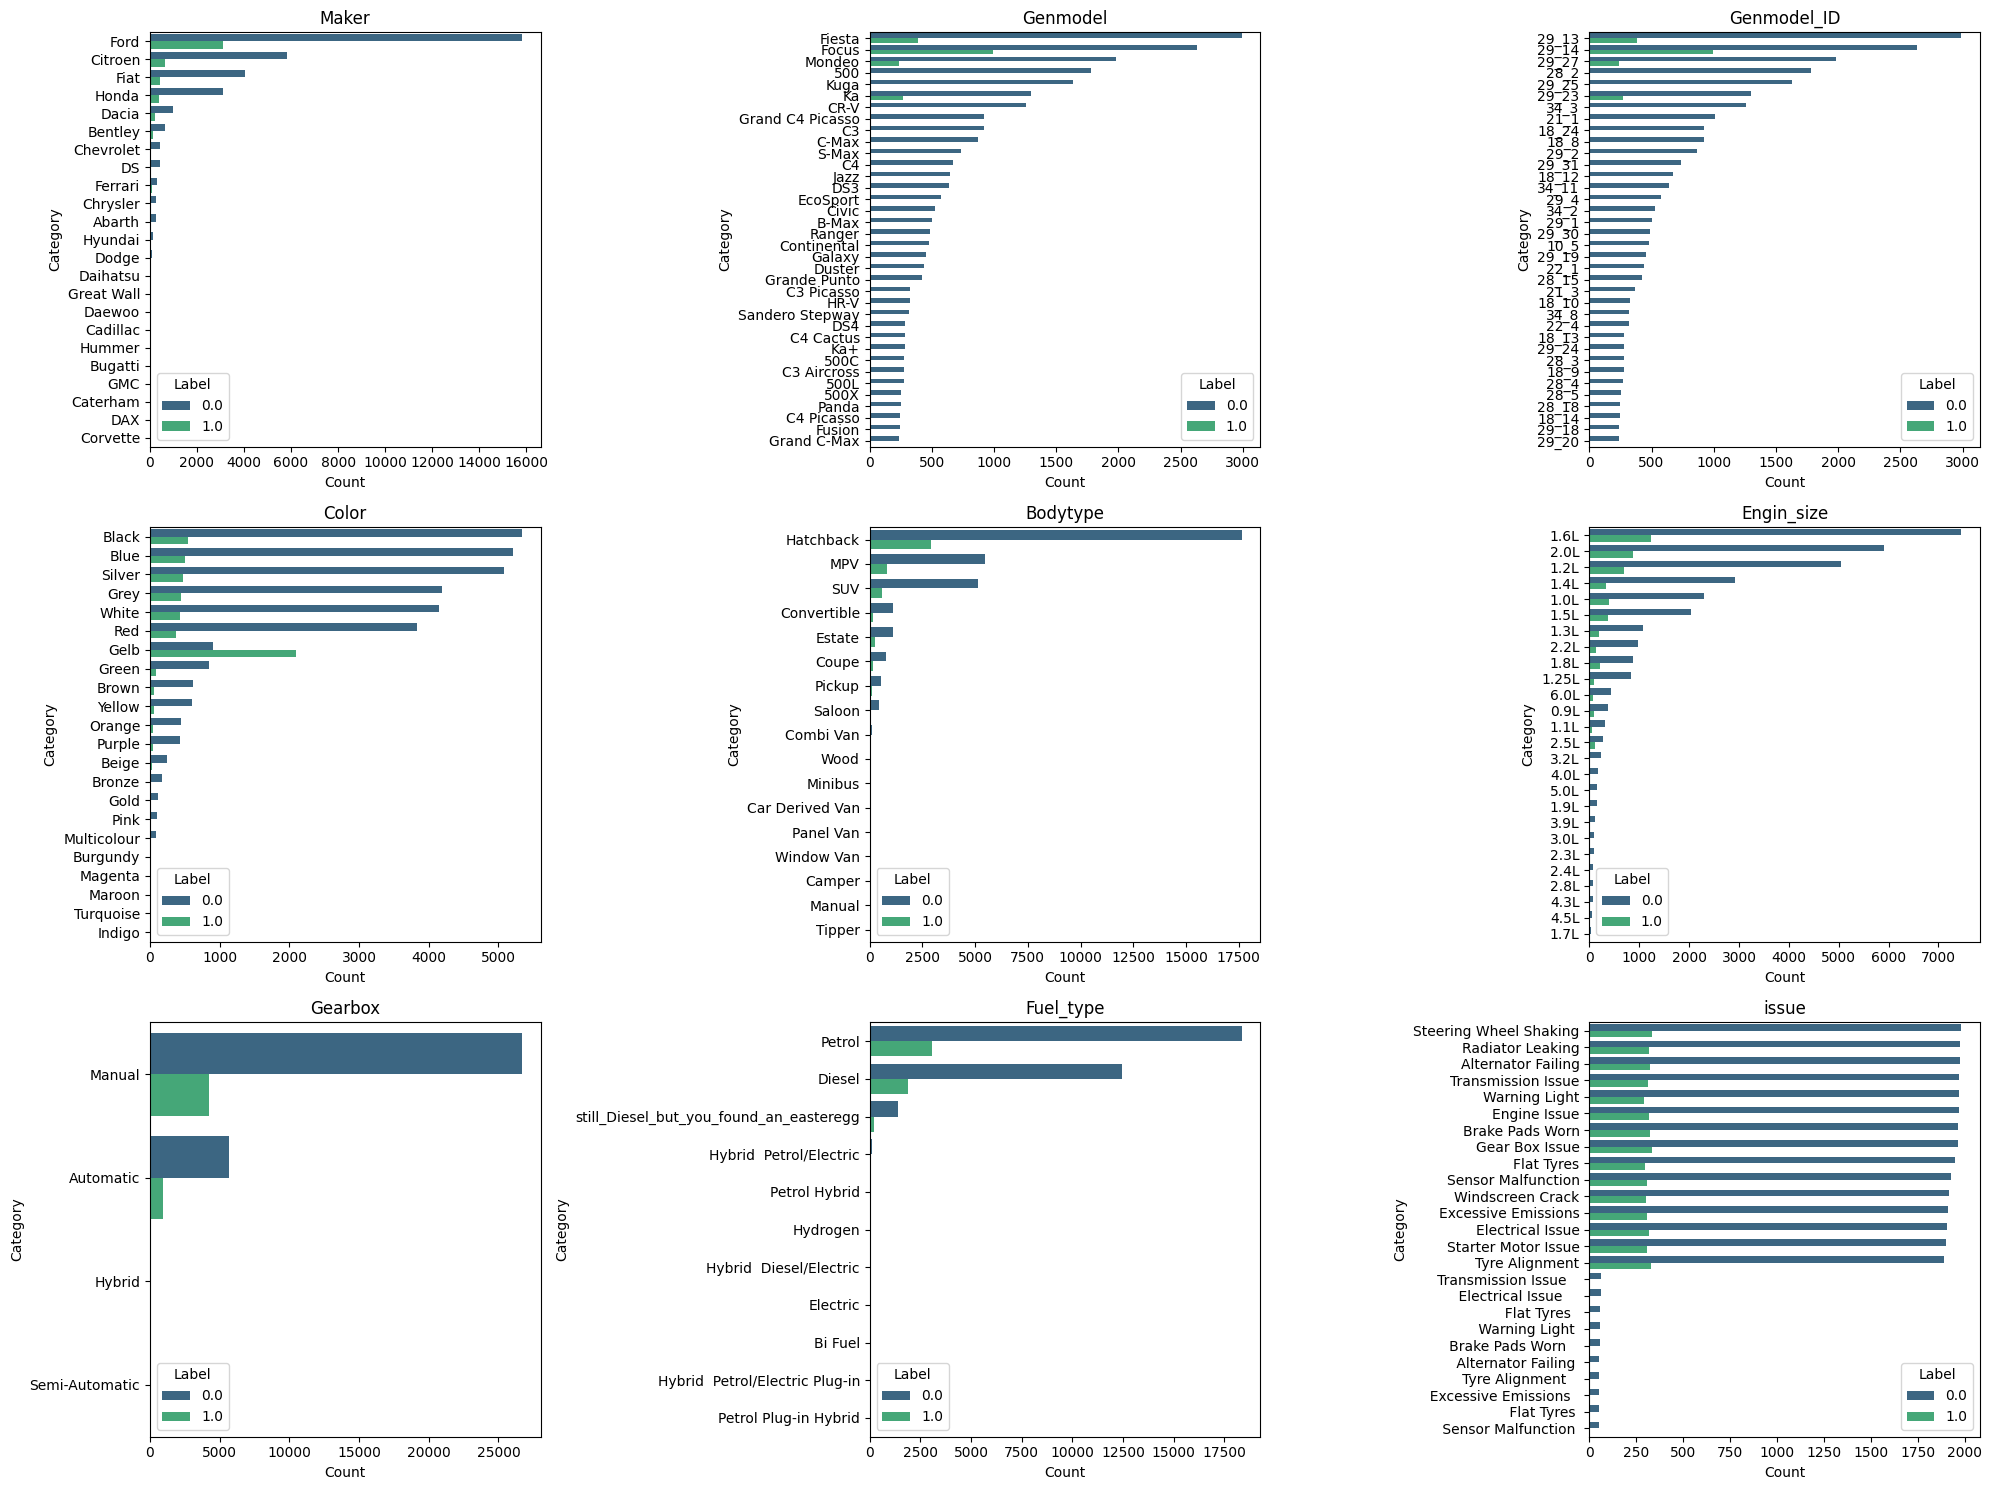

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
    
# Get all string columns
string_columns = [col for col in df.columns if df.schema[col] == pl.Utf8]

# Set up the number of rows and columns for subplots
n_cols = 3
n_rows = (len(string_columns) + n_cols - 1) // n_cols  # Calculate number of rows needed

# Create the figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy indexing

dfpd = df.to_pandas()

# Plotting the top categories for each string column
for i, col in enumerate(string_columns):
    # Get the value counts
    group_col = 'Label'
    top_categories = (dfpd
        .groupby(['Label', col]).size()
        .reset_index(name='Count')
        .sort_values(by='Count', ascending=False)
        .head(20*2)
        .rename(columns={col: 'Category'})
    )
    
    # Convert to a Pandas DataFrame for plotting with Seaborn
    # top_categories_df = top_categories.to_pandas()
    # top_categories_df = top_categories.columns = ['Category', 'Count', 'Label']  # Rename columns for clarity

    # Create the bar plot on the corresponding axes
    sns.barplot(data=top_categories, x='Count', y='Category', hue='Label', palette='viridis', ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('Category')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


#### Fix Colomns Fuel_type and Color

In [8]:
pl.Config.set_fmt_str_lengths(50)
print(df.select(pl.col("Fuel_type")).unique())

shape: (12, 1)
┌─────────────────────────────────────────┐
│ Fuel_type                               │
│ ---                                     │
│ str                                     │
╞═════════════════════════════════════════╡
│ Hybrid  Petrol/Electric                 │
│ Petrol                                  │
│ Hybrid  Diesel/Electric                 │
│ Diesel                                  │
│ Hydrogen                                │
│ Bi Fuel                                 │
│ Petrol Plug-in Hybrid                   │
│ still_Diesel_but_you_found_an_easteregg │
│ Hybrid  Petrol/Electric Plug-in         │
│ Petrol Hybrid                           │
│ Petrol Ethanol                          │
│ Electric                                │
└─────────────────────────────────────────┘
shape: (12, 1)
┌─────────────────────────────────────────┐
│ Fuel_type                               │
│ ---                                     │
│ str                                     │
╞═

In [9]:
# Define the function to replace patterns in the "Fuel_type" column
def replace_with_dict(df: pl.DataFrame, merge_by: dict, col: str) -> pl.DataFrame:
    for pattern, replacement in merge_by.items():
        df = df.with_columns(
            pl.col(col).str.replace(rf".*{pattern}.*", replacement)
        )
    return df

In [10]:
# Dictionary of substrings to search and their replacements
merge_dict = {
    "Hybrid": "Hybrid", 
    "Bi" : "Hybrid",
    "Diesel": "Diesel",
    # note that the order matters, if diesel would be first, those "Diesel/Hybrid" would have been assigned to "Diesel"
}

df = replace_with_dict(df, merge_by=merge_dict, col="Fuel_type")
df = replace_with_dict(df, merge_by={"Gelb": "Yellow"}, col="Color")

#### Fix issue column

In [11]:
df.select(cs.contains("issue"))

def cross_tab(df: pl.DataFrame, index_col: str, pivot_col: str) -> pl.DataFrame:
    cross_tab = df.group_by([index_col, pivot_col]).len().pivot(
        values="len", index=index_col, columns=pivot_col
    )
    new_order = [cross_tab.columns[0]] + sorted(cross_tab.columns[1:])
    return cross_tab.select(new_order)

tbl = cross_tab(df, "issue", "issue_id")
print(tbl)

shape: (90, 7)
┌───────────────────────────┬──────┬──────┬──────┬──────┬──────┬──────┐
│ issue                     ┆ 0    ┆ 1    ┆ 2    ┆ 3    ┆ 4    ┆ 5    │
│ ---                       ┆ ---  ┆ ---  ┆ ---  ┆ ---  ┆ ---  ┆ ---  │
│ str                       ┆ u32  ┆ u32  ┆ u32  ┆ u32  ┆ u32  ┆ u32  │
╞═══════════════════════════╪══════╪══════╪══════╪══════╪══════╪══════╡
│    Starter Motor Issue    ┆ 72   ┆ null ┆ null ┆ null ┆ null ┆ null │
│ Transmission Issue        ┆ null ┆ 1115 ┆ 1107 ┆ 1043 ┆ null ┆ null │
│   Electrical Issue        ┆ null ┆ 19   ┆ 19   ┆ 9    ┆ 14   ┆ 10   │
│    Alternator Failing     ┆ 72   ┆ null ┆ null ┆ null ┆ null ┆ null │
│   Gear Box Issue          ┆ 58   ┆ null ┆ null ┆ null ┆ null ┆ null │
│     Electrical Issue      ┆ null ┆ 19   ┆ 17   ┆ 23   ┆ 14   ┆ 23   │
│ …                         ┆ …    ┆ …    ┆ …    ┆ …    ┆ …    ┆ …    │
│ Windscreen Crack          ┆ 3188 ┆ null ┆ null ┆ null ┆ null ┆ null │
│  Sensor Malfunction       ┆ 81   ┆ null ┆ null 

<positron-console-cell-11>:4: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


In [12]:
# Define the function to strip whitespace in the "issue" column
def strip_issue_whitespace(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns(
        pl.col("issue").str.strip_chars().alias("issue")
    )

# Apply the function
df = strip_issue_whitespace(df)
cross_tab(df, "issue", "issue_id")

<positron-console-cell-12>:4: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.


issue,0,1,2,3,4,5
str,u32,u32,u32,u32,u32,u32
"""Alternator Failing""",3631,null,null,null,null,null
"""Steering Wheel Shaking""",3569,null,null,null,null,null
"""Electrical Issue""",null,689,721,714,713,665
"""Gear Box Issue""",3618,null,null,null,null,null
"""Transmission Issue""",null,1236,1259,1155,null,null
"""Tyre Alignment""",3578,null,null,null,null,null
…,…,…,…,…,…,…
"""Engine Issue""",null,874,915,890,948,null
"""Radiator Leaking""",3606,null,null,null,null,null


In [13]:
pl.Config.set_tbl_rows(99)
df = df.with_columns(
    pl.col("issue").str.strip_chars().alias("issue")
)
print(df.select("issue").unique())
pl.Config.set_tbl_rows(12)

shape: (15, 1)
┌────────────────────────┐
│ issue                  │
│ ---                    │
│ str                    │
╞════════════════════════╡
│ Starter Motor Issue    │
│ Brake Pads Worn        │
│ Flat Tyres             │
│ Gear Box Issue         │
│ Transmission Issue     │
│ Tyre Alignment         │
│ Windscreen Crack       │
│ Radiator Leaking       │
│ Warning Light          │
│ Engine Issue           │
│ Steering Wheel Shaking │
│ Electrical Issue       │
│ Excessive Emissions    │
│ Alternator Failing     │
│ Sensor Malfunction     │
└────────────────────────┘
shape: (15, 1)
┌────────────────────────┐
│ issue                  │
│ ---                    │
│ str                    │
╞════════════════════════╡
│ Starter Motor Issue    │
│ Brake Pads Worn        │
│ Flat Tyres             │
│ Gear Box Issue         │
│ Transmission Issue     │
│ Tyre Alignment         │
│ Windscreen Crack       │
│ Radiator Leaking       │
│ Warning Light          │
│ Engine Issue           

polars.config.Config

### Exploratory: Numeric variables

<Figure size 1000x800 with 0 Axes>

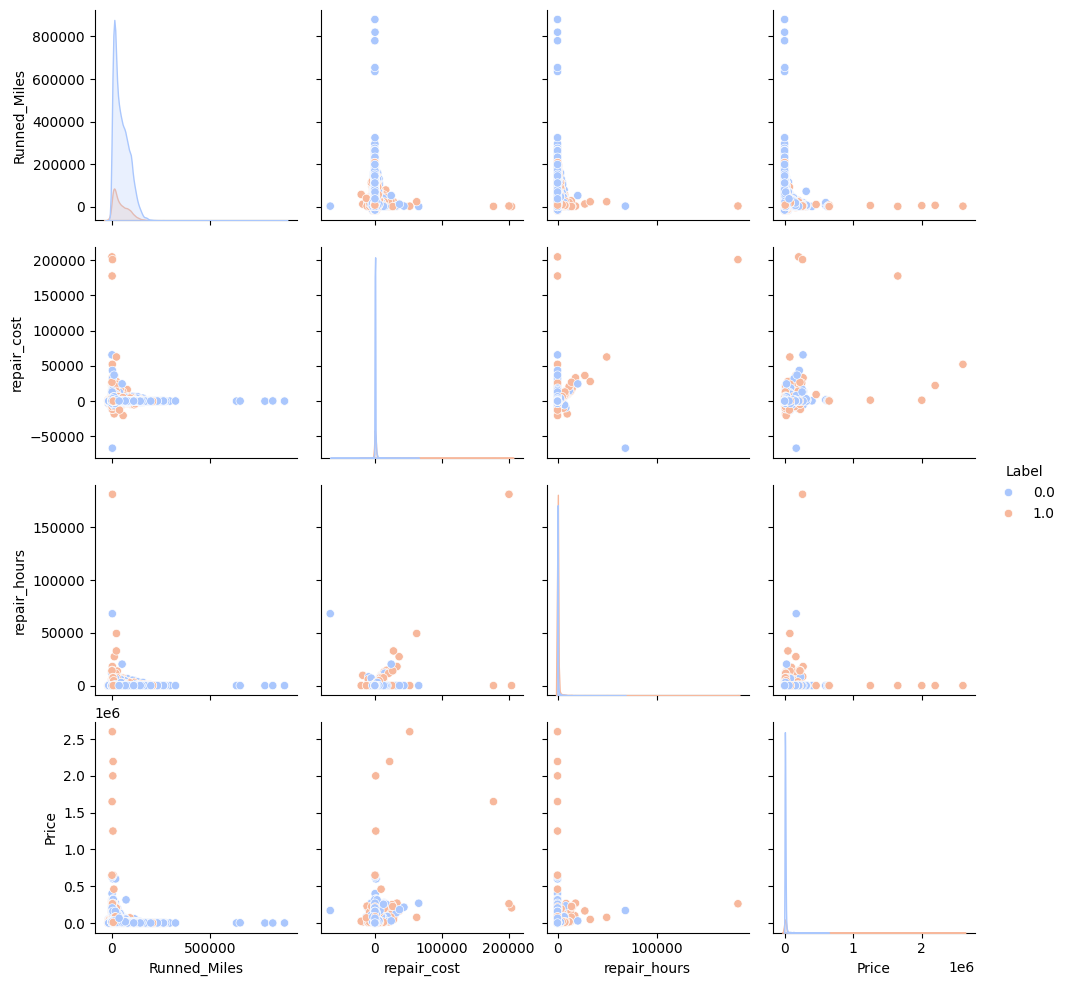

In [14]:
# Plotting some significant features
df_pd = df.to_pandas()
features = ['Runned_Miles', 'repair_cost', 'repair_hours', 'Price']
plt.figure(figsize=(10, 8))
sns.pairplot(df_pd, vars=features, hue='Label', palette='coolwarm')
plt.show()

In [15]:
# Extract positive values as a Polars Series
positive_values = df.filter(pl.col("repair_cost") > 0)["repair_cost"]

# Extract negative values as a Polars Series
negative_values = df.filter(pl.col("repair_cost") < 0)["repair_cost"] * -1


In [16]:
# https://stackoverflow.com/questions/62572067/
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html
from scipy.stats import ks_2samp

ks_2samp_test = ks_2samp(positive_values, negative_values)
print(ks_2samp_test)

KstestResult(statistic=np.float64(0.010015613615608432), pvalue=np.float64(0.7127429241281642), statistic_location=np.float64(74.988), statistic_sign=np.int8(1))
KstestResult(statistic=np.float64(0.010015613615608432), pvalue=np.float64(0.7127429241281642), statistic_location=np.float64(74.988), statistic_sign=np.int8(1))


In [17]:
print(f"p-val: {ks_2samp_test.pvalue:.3f}. kstat: {ks_2samp_test.statistic:.3f}")

p-val: 0.713. kstat: 0.010
p-val: 0.713. kstat: 0.010


Based on the results above (pval=0.954) and kstat=0.009, we cannot reject the null (samples are drawn from same distribution). 

With that, **could we confidently assume that the negative values were just random postive values multiplied by -1?** 

In [18]:
# replace negative values with positive
df = df.with_columns(
    pl.col("repair_cost").abs(),
    pl.col("Runned_Miles").abs()
)

In [19]:
# fix year 2020
df = df.with_columns(
    pl.when(pl.col("Adv_year") == 202)
    .then(2020)
    .otherwise(pl.col("Adv_year"))
    .alias("Adv_year")
)

In [20]:
# Remove "L" and convert to float
df = df.with_columns(
    pl.col("Engin_size")
    .str.replace("L$", "")  # Remove "L" at the end of each string
    .cast(pl.Float64)       # Convert the column to a float
    .alias("Engin_size")
)

In [21]:
# Engin_size 999.0
df_mean_engine_size = (
    df.filter(pl.col("Engin_size") == 999.0)  # Filter rows where value is 999.999
    .group_by("Genmodel_ID")
    .agg(pl.col("value").mean().alias("mean_value"))  # Calculate mean of "value" per ID
)
df_mean_engine_size

# Step 2: Join the mean back to the original DataFrame
df_joined = df.join(df_mean_engine_size, on="Genmodel_ID", how="left")

In [22]:
df.write_csv("df_ongoing.csv")

#### adv_year + adv_month + adv_day

2020 seems to be missing from Adv_year

In [23]:
df["Adv_year"].value_counts(sort=True)

Adv_year,count
i64,u32
2018,47576
2021,3748
2017,1951
2020,350
2016,95
2019,23
2015,14
2014,6
2013,2


In [24]:
# save intermediate dataset
df.write_csv("interdata/df_fixed_01.csv")

In [25]:
df.head()

ID,Maker,Genmodel,Genmodel_ID,Adv_year,Adv_month,Color,Reg_year,Bodytype,Runned_Miles,Engin_size,Gearbox,Fuel_type,Price,Seat_num,Door_num,issue,issue_id,Adv_day,breakdown_date,repair_complexity,repair_cost,repair_hours,repair_date,value,Label
i64,str,str,str,i64,i64,str,i64,str,i64,f64,str,str,i64,i64,i64,str,i64,i64,date,i64,f64,f64,date,f64,i64
16130,"""Ford""","""Ka+""","""29_24""",2018,4,"""Blue""",2017,"""Hatchback""",1636,1.2,"""Manual""","""Petrol""",7490,5,5,"""Tyre Alignment""",0,15,2018-04-15,1,10.749,0.5,2018-04-15,7116.045727,0
16131,"""Ford""","""Edge""","""29_5""",2018,5,"""Blue""",2016,"""SUV""",9820,2.0,"""Manual""","""Diesel""",23995,5,5,"""Radiator Leaking""",0,20,2018-05-20,1,519.9,2.0,2018-05-20,22790.624277,0
16132,"""Honda""","""CR-V""","""34_3""",2018,8,"""Grey""",2012,"""SUV""",38500,2.2,"""Automatic""","""Diesel""",11750,5,5,"""Sensor Malfunction""",0,26,2018-08-26,1,3059.099027,2172.572165,2018-08-29,11158.396445,1
16133,"""Ford""","""Kuga""","""29_25""",2018,5,"""Silver""",2012,"""SUV""",43445,2.0,"""Manual""","""Diesel""",9999,5,5,"""Gear Box Issue""",0,6,2018-05-06,1,571.012064,437.382279,2018-05-25,9492.344018,1
16134,"""Honda""","""CR-V""","""34_3""",2018,6,"""Grey""",2018,"""SUV""",7491,1.6,"""Manual""","""Diesel""",21999,5,5,"""Alternator Failing""",0,5,2018-06-05,1,479.98,2.0,2018-06-05,20903.668754,0
